## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import pandas as pd
import pydot as pyd
from itertools import chain

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [5]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [6]:
X_data = encoder_input_data[:1000]
Y_data = decoder_input_data[:1000]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (1000, 3822, 4)
Y_data (1000, 3822, 4)


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17481942360408986505
xla_global_id: -1
]


## Construct model

In [25]:
n_hidden = 256

In [26]:
input_train = Input(shape=(X_data.shape[1], X_data.shape[2]))
output_train = Input(shape=(Y_data.shape[1], Y_data.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [27]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, dropout = 0.05, recurrent_dropout = 0.05, # , activation = 'elu'
    return_sequences = True, return_state = True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 256), dtype=tf.float32, name=None), name='lstm_2/transpose_1:0', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='lstm_2/while:4', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='lstm_2/while:5', description="created by layer 'lstm_2'")


In [28]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum = 0.6)(encoder_last_c)

In [29]:
decoder_input = RepeatVector(Y_data.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 256), dtype=tf.float32, name=None), name='repeat_vector_1/Tile:0', description="created by layer 'repeat_vector_1'")


In [30]:
decoder_stack_h = LSTM(n_hidden, dropout = 0.01, recurrent_dropout = 0.01, # , activation='elu'
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = [encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 256), dtype=tf.float32, name=None), name='lstm_3/transpose_1:0', description="created by layer 'lstm_3'")


In [31]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 3822), dtype=tf.float32, name=None), name='activation_1/Softmax:0', description="created by layer 'activation_1'")


In [32]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 256), dtype=tf.float32, name=None), name='batch_normalization_5/batchnorm/add_1:0', description="created by layer 'batch_normalization_5'")


In [33]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 512), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


In [34]:
out = TimeDistributed(Dense(Y_data.shape[2], activation = "softmax"))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [35]:
model = Model(inputs = input_train, outputs = out)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3822, 4)]    0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 3822, 256),  267264      ['input_3[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 256)         1024        ['lstm_2[0][1]']                 
 rmalization)                                                                               

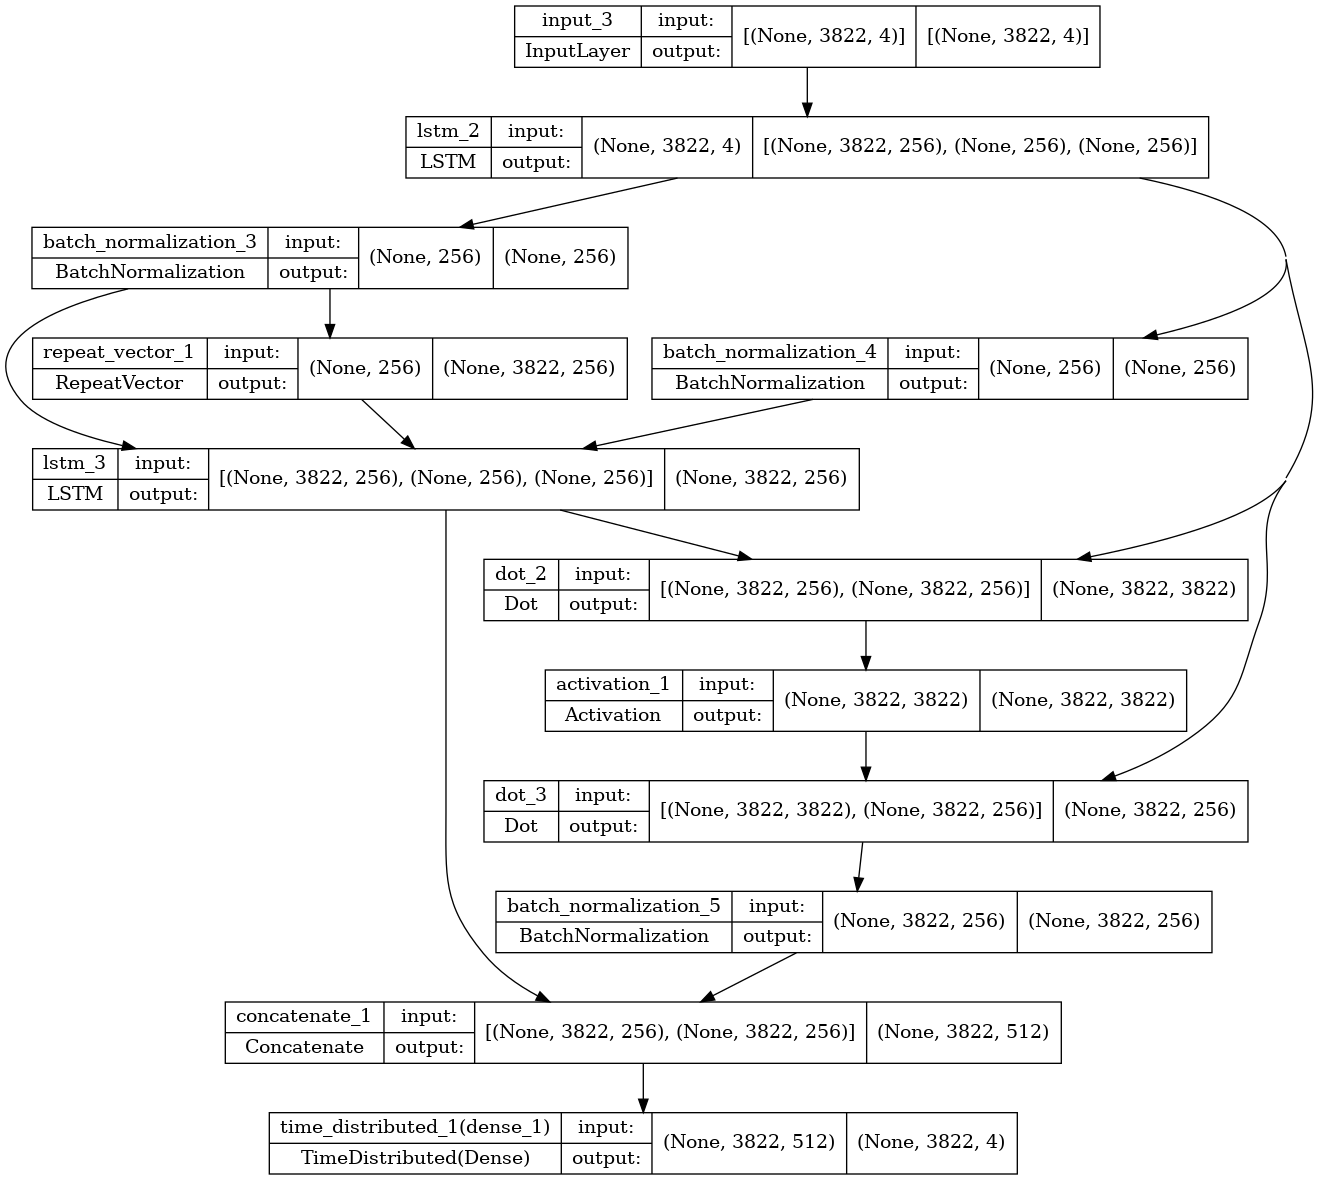

In [36]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train model

In [37]:
batch_size = 16      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 100         # Number of epochs to train for.

In [38]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit(X_data, Y_data, validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)
train_mae = history.history['accuracy']
valid_mae = history.history['val_accuracy']

Epoch 1/100
50/50 [==============================] - 656s 13s/step - loss: 1.3627 - accuracy: 0.3270 - val_loss: 1.3528 - val_accuracy: 0.3328
Epoch 2/100
50/50 [==============================] - 635s 13s/step - loss: 1.3523 - accuracy: 0.3329 - val_loss: 1.3522 - val_accuracy: 0.3328
Epoch 3/100
50/50 [==============================] - 641s 13s/step - loss: 1.3507 - accuracy: 0.3328 - val_loss: 1.3496 - val_accuracy: 0.3328
Epoch 4/100
50/50 [==============================] - 623s 12s/step - loss: 1.3485 - accuracy: 0.3333 - val_loss: 1.3472 - val_accuracy: 0.3341
Epoch 5/100
50/50 [==============================] - 635s 13s/step - loss: 1.3451 - accuracy: 0.3349 - val_loss: 1.3435 - val_accuracy: 0.3356
Epoch 6/100
34/50 [===================>..........] - ETA: 3:10 - loss: 1.3456 - accuracy: 0.3323

KeyboardInterrupt: 

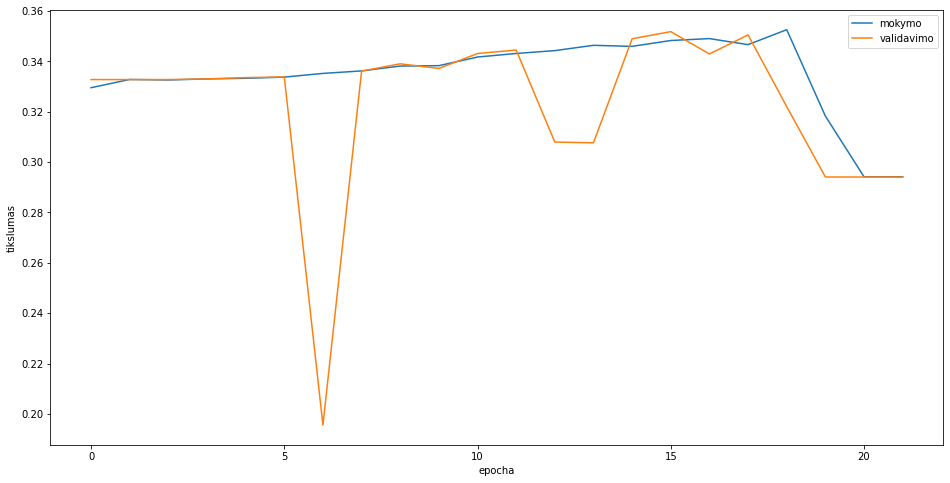

In [22]:
plt.plot(train_mae, label = 'mokymo')
plt.plot(valid_mae, label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

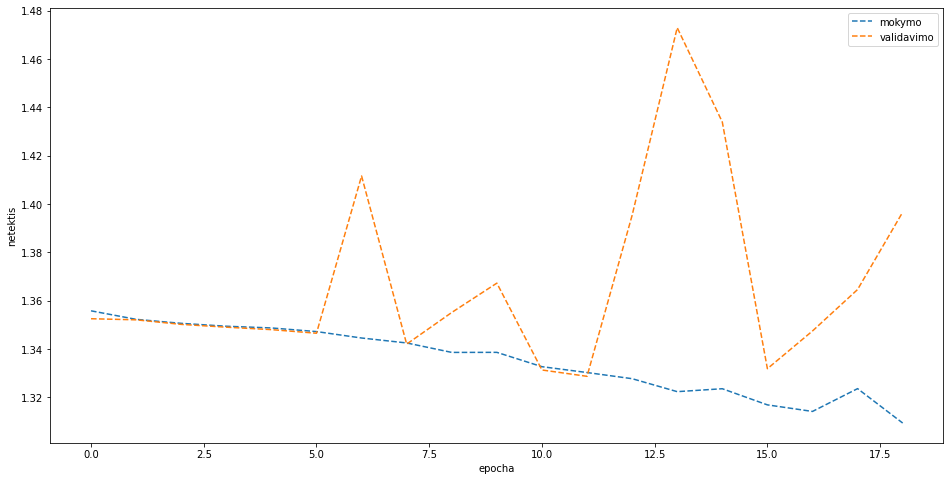

In [23]:
plt.plot(history.history['loss'], '--', label = 'mokymo')
plt.plot(history.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [24]:
model.save("data/ncbi_02/06-ncbi-lstm-att-batch-model")

INFO:tensorflow:Assets written to: data/ncbi_02/06-ncbi-lstm-att-batch-model/assets
